## Supersonic Flow over Flat plate

In [1]:
import numpy
from matplotlib import pyplot    
%matplotlib inline
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

In [2]:
# Initial Conditions
gamma = 1.4
#Velocity
M = 4.0 #mach number
c_inf = 340.28 #speed of sound m/s
u_inf = M*c_inf
v_inf = 0.0
V_inf = numpy.sqrt(u_inf**2 + v_inf**2 )
#
R = 287 # J/(kg*K)
T_inf = 288.16 #Kelvin
P_inf = 101325 #N/m^2
rho_inf = P_inf/(R*T_inf)
Pr = 0.71 #prandtl no.
dyn_visc = 1.7894e-5 #kg/(m*s)
lmbda = -(2./3.)*dyn_visc # second viscosity coefficient
gamma = 1.4

#specific heat
cv = R/(gamma-1.)
cp = gamma*cv

e_inf = cv*T_inf
#Boundary Conditions
#no slip:
T_wall = T_inf #Kelvin

In [3]:
# Parameters
L = 1e-5 #length of plate

Re = (rho_inf*V_inf*L)/dyn_visc

#Grid
Y = (25*L)/numpy.sqrt(Re)
n = 70 #number of grid points

#space steps:
dx = L/(n-1)
dy = Y/(n-1)
#x = numpy.linspace(0,L,n)

In [4]:
def get_Uinitial(rho_fs, ufs, vfs, Vfs, Tfs, efs):
    """
    Parameters:
    -----------
    """
    #---------------------------------------------
    U_start = numpy.zeros((4,70,70),dtype=float)
    #
    U_start[0,:,:] = rho_fs
    #
    U_start[1,:,1:] = rho_fs*ufs
    U_start[1,:,0] = 0.0 #no slip on plate including leading edge
    #
    U_start[2,:,:] = rho_fs*vfs
    U_start[2,:,0] = 0.0 #no slip on plate including leading edge
    #
    U_start[3,:,1:] = (efs + 0.5*(Vfs**2))*rho_fs
    U_start[3,:,0] = (T_wall*cv)*rho_fs #no slip
    
    return U_start  

In [5]:
def get_Temperature(Uv):
    #
    TT = numpy.zeros((n,n))
    #
    #interior points
    TT[1:-1,1:-1] = (1/cv)*\
                    ((Uv[3,1:-1,1:-1]/Uv[0,1:-1,1:-1]) -\
                     0.5*( (Uv[1,1:-1,1:-1]/Uv[0,1:-1,1:-1])**2 + (Uv[2,1:-1,1:-1]/Uv[0,1:-1,1:-1])**2 ))
    #
    #enforce BCS:
    TT[1:,0] = T_wall  #at plate x-line
    TT[0,0] = T_inf #leading edge
    TT[:,-1] = T_inf #at top x-line
    TT[0,:] = T_inf  #at inflow y-line
    
    #at outflow:
    TT[-1,1:-1] = 2*TT[-2,1:-1] - TT[-3,1:-1] #at outflow y-line, extrapolate
    #
    return TT

In [6]:
def get_visc(Temp):
    """
    Sutherland's law
    """
    v = numpy.zeros_like(Temp)
    #
    v[:,1:] = dyn_visc*((Temp[:,1:]/T_inf)**(3./2.))*(T_inf+110.)/(Temp[:,1:]+110)
    v[:,0] = dyn_visc # at plate: T_inf/T = 1
    #
    return v

In [7]:
def get_k(visc):
    #
    kk = numpy.zeros_like(visc)
    #
    kk[:,:] = visc[:,:]*cp/Pr
    #
    return kk

In [8]:
def get_BC(Uv, Temp):
    #
    Ubc = Uv.copy()
    #
    #density
    Ubc[0,0,0] = rho_inf #leading edge
    Ubc[0,1:,0] = (2*R*Uv[0,1:,1]*Temp[1:,1] - R*Uv[0,1:,2]*Temp[1:,2])/(R*T_wall) #density at plate
    Ubc[0,0,1:] = rho_inf #inflow
    Ubc[0,1:,-1] = rho_inf #top
    #
    #x-mom:
    Ubc[1,:,0] = 0.0 #plate and leading edge
    Ubc[1,0,1:] = rho_inf*u_inf #inflow
    Ubc[1,1:,-1] = rho_inf*u_inf #top
    #y-mom:
    Ubc[2,:,0] = 0.0 #plate and leading edge
    Ubc[2,0,1:] = 0.0 #inflow
    Ubc[2,1:,-1] = 0.0 #top
    #
    #E_total:
    Ubc[3,:,0] = rho_inf*(cv*T_inf) #plate and leading edge
    Ubc[3,0,1:] = rho_inf*(cv*T_inf + 0.5*u_inf**2) #inflow
    Ubc[3,1:,-1] = rho_inf*(cv*T_inf + 0.5*u_inf**2) #top
    #
    #at outflow, u,v, P, and T are extrapolated, then:
    uout = numpy.zeros((n-2))
    vout = numpy.zeros((n-2))
    Pout = numpy.zeros((n-2))
    #
    uout[:] = 2*Uv[1,-2,1:-1]/Uv[0,-2,1:-1] - Uv[1,-3,1:-1]/Uv[0,-3,1:-1]
    vout[:] =  2*Uv[2,-2,1:-1]/Uv[0,-2,1:-1] - Uv[2,-3,1:-1]/Uv[0,-3,1:-1]
    Pout[:] = 2*Uv[0,-2,1:-1]*R*Temp[-2,1:-1] - Uv[0,-3,1:-1]*R*Temp[-3,1:-1]
    #
    Ubc[0,-1,1:-1] = Pout[:]/(R*Temp[-1,1:-1])
    Ubc[1,-1,1:-1] = Ubc[0,-1,1:-1] * uout[:]
    Ubc[2,-1,1:-1] = Ubc[0,-1,1:-1] * vout[:]
    Ubc[3,-1,1:-1] = Ubc[0,-1,1:-1]*(Temp[-1,1:-1]*cv + 0.5*(uout[:]**2 + vout[:]**2))
    #
    return Ubc

## Predictor Functions

In [9]:
def get_tau_xy_predict(Uv, visc):
    #define
    tau_xy = numpy.zeros((n,n))
    #at plate, exclude leading edge and ouflow point
    # i backward and j forward
    tau_xy[1:-1,0] = visc[1:-1,0]*((Uv[1,1:-1,1]/Uv[0,1:-1,1] - Uv[1,1:-1,0]/Uv[0,1:-1,0])/dy +\
                                   (Uv[2,1:-1,0]/Uv[0,1:-1,0] - Uv[2,:-2,0]/Uv[0,:-2,0])/dx)
    #at inflow, including leading edge, excluding upper boundary:
    #i and j forward
    tau_xy[0,:-1] = visc[0,:-1]*((Uv[1,0,1:]/Uv[0,0,1:] - Uv[1,0,:-1]/Uv[0,0,:-1])/dy +\
                                   (Uv[2,1,:-1]/Uv[0,1,:-1] - Uv[2,0,:-1]/Uv[0,0,:-1])/dx)
    #at upper boundary, excluding outflow point and inflow point:
    # i back j back
    tau_xy[1:-1,-1] = visc[1:-1,-1]*((Uv[1,1:-1,-1]/Uv[0,1:-1,-1] - Uv[1,1:-1,-2]/Uv[0,1:-1,-2])/dy +\
                                   (Uv[2,1:-1,-1]/Uv[0,1:-1,-1] - Uv[2,:-2,-1]/Uv[0,:-2,-1])/dx)

    #   #inner points:
    #i back j central
    tau_xy[1:-1,1:-1] = visc[1:-1,1:-1]*( (1/(2*dy))*((Uv[1,1:-1,2:]/Uv[0,1:-1,2:])-(Uv[1,1:-1,:-2]/Uv[0,1:-1,:-2])) +\
                                      (1/dx)*((Uv[2,1:-1,1:-1]/Uv[0,1:-1,1:-1])-(Uv[2,:-2,1:-1]/Uv[0,:-2,1:-1])) )
    #upper inflow
    # i forward j backward
    tau_xy[0,-1] = visc[0,-1]*((Uv[1,0,-1]/Uv[0,0,-1] - Uv[1,0,-2]/Uv[0,0,-2])/dy +\
                                   (Uv[2,1,-1]/Uv[0,1,-1] - Uv[2,0,-1]/Uv[0,0,-1])/dx)
    #upper outflow
    #i back j back
    tau_xy[-1,-1] = visc[-1,-1]*((Uv[1,-1,-1]/Uv[0,-1,-1] - Uv[1,-1,-2]/Uv[0,-1,-2])/dy +\
                                   (Uv[2,-1,-1]/Uv[0,-1,-1] - Uv[2,-2,-1]/Uv[0,-2,-1])/dx) 
    #outflow:
    #i back j central
    tau_xy[-1,1:-1] = visc[-1,1:-1]*((Uv[1,-1,2:]/Uv[0,-1,2:] - Uv[1,-1,:-2]/Uv[0,-1,:-2])/(2*dy) +\
                                   (Uv[2,-1,1:-1]/Uv[0,-1,1:-1] - Uv[2,-2,1:-1]/Uv[0,-2,1:-1])/dx)
    return tau_xy

In [10]:
def get_tau_xx_predict(Uv, visc):
    #velocity magnitude:
    V = numpy.zeros_like(Uv)
    V = numpy.abs(numpy.sqrt( (Uv[1,:,:]/Uv[0,:,:])**2 + (Uv[2,:,:]/Uv[0,:,:])**2 ) )
    tau_xx = numpy.zeros((n,n))
    #at plate, exclude leading edge and ouflow point
    # i backward and j forward
    tau_xx[1:-1,0] = lmbda * ( (V[1:-1,0]-V[:-2,0])/dx + (V[1:-1,1] - V[1:-1,0])/dy ) +\
                     2*visc[1:-1,0]*( Uv[1,1:-1,0]/Uv[0,1:-1,0] - Uv[1,:-2,0]/Uv[0,:-2,0] )/dx
    #at inflow, including leading edge, excluding upper boundary:
    #i and j forward
    tau_xx[0,:-1] = lmbda * ( (V[1,:-1]-V[0,:-1])/dx + (V[0,1:] - V[0,:-1])/dy ) +\
                     2*visc[0,:-1]*( Uv[1,1,:-1]/Uv[0,1,:-1] - Uv[1,0,:-1]/Uv[0,0,:-1] )/dx
    #upper boundary, excluding outflow and inflow points:
    #i and j backward
    tau_xx[1:-1,-1] = lmbda * ( (V[1:-1,-1]-V[:-2,-1])/dx + (V[1:-1,-1] - V[1:-1,-2])/dy ) +\
                     2*visc[1:-1,-1]*( Uv[1,1:-1,-1]/Uv[0,1:-1,-1] - Uv[1,:-2,-1]/Uv[0,:-2,-1] )/dx
    #inner points
    # i backward, j central
    tau_xx[1:-1,1:-1] = lmbda*((V[1:-1,1:-1]-V[:-2,1:-1])/dx + (V[1:-1,2:]-V[1:-1,:-2])/(2*dy))+\
                       (2*visc[1:-1,1:-1]*(1/dx)*((Uv[1,1:-1,1:-1]/Uv[0,1:-1,1:-1])-(Uv[1,:-2,1:-1]/Uv[0,:-2,1:-1])))
    #upper inflow
    # i forward j backward
    tau_xx[0,-1] = lmbda * ( (V[1,-1]-V[0,-1])/dx + (V[0,-1] - V[0,-2])/dy ) +\
                     2*visc[0,-1]*( Uv[1,1,-1]/Uv[0,1,-1] - Uv[1,0,-1]/Uv[0,0,-1] )/dx
    #upper outflow
    # i and j back
    tau_xx[-1,-1] = lmbda * ( (V[-1,-1]-V[-2,-1])/dx + (V[-1,-1] - V[-1,-2])/dy ) +\
                     2*visc[-1,-1]*( Uv[1,-1,-1]/Uv[0,-1,-1] - Uv[1,-2,-1]/Uv[0,-2,-1])/dx
    #outflow:
    #i back j central
    tau_xx[-1,1:-1] = lmbda * ( (V[-1,1:-1]-V[-2,1:-1])/dx + (V[-1,2:] - V[-1,:-2])/(2*dy) ) +\
                     2*visc[-1,1:-1]*( Uv[1,-1,1:-1]/Uv[0,-1,1:-1] - Uv[1,-2,1:-1]/Uv[0,-2,1:-1] )/dx
    
    return tau_xx

In [11]:
def get_tau_yy_predict(Uv, visc):
        #velocity magnitude:
    V = numpy.zeros_like(Uv)
    V = numpy.abs(numpy.sqrt( (Uv[1,:,:]/Uv[0,:,:])**2 + (Uv[2,:,:]/Uv[0,:,:])**2 ) )
    tau_yy = numpy.zeros((n,n))
    #at plate, exclude leading edge and ouflow point
    # i backward and j forward
    tau_yy[1:-1,0] = lmbda * ( (V[1:-1,0]-V[:-2,0])/dx + (V[1:-1,1] - V[1:-1,0])/dy ) +\
                     2*visc[1:-1,0]*( Uv[2,1:-1,1]/Uv[0,1:-1,1] - Uv[2,1:-1,0]/Uv[0,1:-1,0] )/dy
    #at inflow, including leading edge, excluding upper boundary:
    #i and j forward
    tau_yy[0,:-1] = lmbda * ( (V[1,:-1]-V[0,:-1])/dx + (V[0,1:] - V[0,:-1])/dy ) +\
                     2*visc[0,:-1]*( Uv[2,0,1:]/Uv[0,0,1:] - Uv[2,0,:-1]/Uv[0,0,:-1] )/dy
    #upper boundary, excluding outflow and inflow points:
    #i and j backward
    tau_yy[1:-1,-1] = lmbda * ( (V[1:-1,-1]-V[:-2,-1])/dx + (V[1:-1,-1] - V[1:-1,-2])/dy ) +\
                     2*visc[1:-1,-1]*( Uv[2,1:-1,-1]/Uv[0,1:-1,-1] - Uv[2,1:-1,-2]/Uv[0,1:-1,-2] )/dy
    #inner points
    # i backward, j central
    tau_yy[1:-1,1:-1] = lmbda*((V[1:-1,1:-1]-V[:-2,1:-1])/dx + (V[1:-1,2:]-V[1:-1,:-2])/(2*dy))+\
                       (2*visc[1:-1,1:-1]*(1/(2*dy))*((Uv[2,1:-1,2:]/Uv[0,1:-1,2:])-(Uv[2,1:-1,:-2]/Uv[0,1:-1,:-2])))
    #upper inflow
    # i forward j backward
    tau_yy[0,-1] =  lmbda * ( (V[1,-1]-V[0,-1])/dx + (V[0,-1] - V[0,-2])/dy ) +\
                     2*visc[0,-1]*( Uv[2,0,-1]/Uv[0,0,-1] - Uv[2,0,-2]/Uv[0,0,-2] )/dy
    #upper outflow
    # i and j back
    tau_yy[-1,-1] = lmbda * ( (V[-1,-1]-V[-2,-1])/dx + (V[-1,-1] - V[-1,-2])/dy ) +\
                     2*visc[-1,-1]*( Uv[2,-1,-1]/Uv[0,-1,-1] - Uv[2,-1,-2]/Uv[0,-1,-2] )/dy 
    #outflow:
    #i back j central
    tau_yy[-1,1:-1] = lmbda*((V[-1,1:-1]-V[-2,1:-1])/dx + (V[-1,2:]-V[-1,:-2])/(2*dy))+\
                       (2*visc[-1,1:-1]*(1/(2*dy))*((Uv[2,-1,2:]/Uv[0,-1,2:])-(Uv[2,-1,:-2]/Uv[0,-1,:-2])))
    return tau_yy

In [12]:
def get_E_flux_predictor(Uv, visc, Temp, kc, txx, txy):
    #
    Ev= numpy.zeros_like(Uv)
    qx = numpy.zeros((n,n))
    qx[1:,1:-1] = -kc[1:,1:-1]*(Temp[1:,1:-1]-Temp[:-1,1:-1])/dx # i=1: for forward Diff of E
    #
    Ev[0,:,:] = Uv[1,:,:]
    Ev[1,:,:] = (Uv[1,:,:]**2)/Uv[0,:,:] + Uv[0,:,:]*R*Temp[:,:] - txx[:]
    Ev[2,:,:] = Uv[1,:,:]*Uv[2,:,:]/Uv[0,:,:] - txy[:]
    Ev[3,:,:] = (Uv[1,:,:]/Uv[0,:,:])*(Uv[3,:,:] + Uv[0,:,:]*R*Temp[:,:]) -\
                (Uv[1,:,:]/Uv[0,:,:])*txx[:] - (Uv[2,:,:]/Uv[0,:,:])*txy + qx[:,:]
    return Ev

In [13]:
def get_F_flux_predictor(Uv, visc, Temp, kc, txy, tyy):
        #
    Fv= numpy.zeros_like(Uv)
    qy = numpy.zeros((n,n))
    qy[1:-1,1:] = -kc[1:-1,1:]*(Temp[1:-1,1:]-Temp[1:-1,:-1])/dy
    #
    Fv[0,:,:] = Uv[2,:,:]
    Fv[1,:,:] = Uv[1,:,:]*Uv[2,:,:]/Uv[0,:,:] - txy[:]
    Fv[2,:,:] = (Uv[2,:,:]**2)/Uv[0,:,:] + Uv[0,:,:]*R*Temp[:,:] - txy[:]
    Fv[3,:,:] = (Uv[2,:,:]/Uv[0,:,:])*(Uv[3,:,:] + Uv[0,:,:]*R*Temp[:,:]) -\
                (Uv[1,:,:]/Uv[0,:,:])*txy[:] - (Uv[2,:,:]/Uv[0,:,:])*tyy + qy[:,:]
    return Fv

In [14]:
def get_dt(Uv, visc, Temp):
    K=0.6
    dt_cfl = numpy.zeros((n-2,n-2))
    dt_cfl[:,:] = ((numpy.abs(Uv[1,1:-1,1:-1]/Uv[0,1:-1,1:-1]))/dx + (numpy.abs(Uv[2,1:-1,1:-1]/Uv[0,1:-1,1:-1]))/dy +\
                   numpy.sqrt(gamma*R*Temp[1:-1,1:-1])*numpy.sqrt( 1/(dx**2) + 1/(dy**2) ) +\
                   2*numpy.max( ((4/3)*visc[1:-1,1:-1]*(gamma*visc[1:-1,1:-1]/Pr))/Uv[0,1:-1,1:-1] )*\
                    ( 1/(dx**2) + 1/(dy**2) ) )**(-1)
    delt = numpy.min(K*dt_cfl[:,:])
    return delt

## Corrector Functions

In [15]:
def get_tau_xy_correct(Uv, visc):
    #define
    tau_xy = numpy.zeros((n,n))
    #at plate, exclude leading edge and ouflow point
    # i forward, j forward
    tau_xy[1:-1,0] = visc[1:-1,0]*((Uv[1,1:-1,1]/Uv[0,1:-1,1] - Uv[1,1:-1,0]/Uv[0,1:-1,0])/dy +\
                                   (Uv[2,2:,0]/Uv[0,2:,0] - Uv[2,1:-1,0]/Uv[0,1:-1,0])/dx)
    #at inflow, including leading edge, excluding upper boundary:
    # i forward, j forward
    tau_xy[0,:-1] = visc[0,:-1]*((Uv[1,0,1:]/Uv[0,0,1:] - Uv[1,0,:-1]/Uv[0,0,:-1])/dy +\
                                   (Uv[2,1,:-1]/Uv[0,1,:-1] - Uv[2,0,:-1]/Uv[0,0,:-1])/dx)
    #at upper boundary, excluding outflow point and inflow point:
    # i forward, j backward
    tau_xy[1:-1,-1] = visc[1:-1,-1]*((Uv[1,1:-1,-1]/Uv[0,1:-1,-1] - Uv[1,1:-1,-2]/Uv[0,1:-1,-2])/dy +\
                                   (Uv[2,2:,-1]/Uv[0,2:,-1] - Uv[2,1:-1,-1]/Uv[0,1:-1,-1])/dx)

    #inner points:
    # i forward, j central
    tau_xy[1:-1,1:-1] = visc[1:-1,1:-1]*( (1/(2*dy))*((Uv[1,1:-1,2:]/Uv[0,1:-1,2:])-(Uv[1,1:-1,:-2]/Uv[0,1:-1,:-2])) +\
                                      (1/dx)*((Uv[2,2:,1:-1]/Uv[0,2:,1:-1])-(Uv[2,1:-1,1:-1]/Uv[0,1:-1,1:-1])) )
    #upper inflow:
    # i forward , j backward
    tau_xy[0,-1] = visc[0,-1]*((Uv[1,0,-1]/Uv[0,0,-1] - Uv[1,0,-2]/Uv[0,0,-2])/dy +\
                                   (Uv[2,1,-1]/Uv[0,1,-1] - Uv[2,0,-1]/Uv[0,0,-1])/dx)
    #upper outflow
    ##i back, j back
    tau_xy[-1,-1] = visc[-1,-1]*((Uv[1,-1,-1]/Uv[0,-1,-1] - Uv[1,-1,-2]/Uv[0,-1,-2])/dy +\
                                   (Uv[2,-1,-1]/Uv[0,-1,-1] - Uv[2,-2,-1]/Uv[0,-2,-1])/dx) 
    #outflow:
    # i back, j central
    tau_xy[-1,1:-1] = visc[-1,1:-1]*((Uv[1,-1,2:]/Uv[0,-1,2:] - Uv[1,-1,:-2]/Uv[0,-1,:-2])/(2*dy) +\
                                   (Uv[2,-1,1:-1]/Uv[0,-1,1:-1] - Uv[2,-2,1:-1]/Uv[0,1,1:-1])/dx)
    return tau_xy

In [16]:
def get_tau_xx_correct(Uv, visc):
    #velocity magnitude:
    V = numpy.zeros_like(Uv)
    V = numpy.abs(numpy.sqrt( (Uv[1,:,:]/Uv[0,:,:])**2 + (Uv[2,:,:]/Uv[0,:,:])**2 ) )
    tau_xx = numpy.zeros((n,n))
    #at plate, exclude leading edge and ouflow point
    # i forward, j forward
    tau_xx[1:-1,0] = lmbda * ( (V[2:,0]-V[1:-1,0])/dx + (V[1:-1,1] - V[1:-1,0])/dy ) +\
                     2*visc[1:-1,0]*( Uv[1,2:,0]/Uv[0,2:,0] - Uv[1,1:-1,0]/Uv[0,1:-1,0] )/dx
    #at inflow, including leading edge, excluding upper boundary:
    # i forward, j forward
    tau_xx[0,:-1] = lmbda * ( (V[1,:-1]-V[0,:-1])/dx + (V[0,1:] - V[0,:-1])/dy ) +\
                     2*visc[0,:-1]*( Uv[1,1,:-1]/Uv[0,1,:-1] - Uv[1,0,:-1]/Uv[0,0,:-1] )/dx
    #upper boundary, excluding outflow and inflow points:
    # i forward, j backward
    tau_xx[1:-1,-1] = lmbda * ( (V[2:,-1]-V[1:-1,-1])/dx + (V[1:-1,-1] - V[1:-1,-2])/dy ) +\
                     2*visc[1:-1,-1]*( Uv[1,2:,-1]/Uv[0,2:,-1] - Uv[1,1:-1,-1]/Uv[0,1:-1,-1] )/dx
    #inner points
    # i forward, j central
    tau_xx[1:-1,1:-1] = lmbda*((V[2:,1:-1]-V[1:-1,1:-1])/dx + (V[1:-1,2:]-V[1:-1,:-2])/(2*dy))+\
                       (2*visc[1:-1,1:-1]*(1/dx)*((Uv[1,2:,1:-1]/Uv[0,2:,1:-1])-(Uv[1,1:-1,1:-1]/Uv[0,1:-1,1:-1])))
    #upper inflow
    # i forward, j backward
    tau_xx[0,-1] = lmbda * ( (V[1,-1]-V[0,-1])/dx + (V[0,-1] - V[0,-2])/dy ) +\
                     2*visc[0,-1]*( Uv[1,1,-1]/Uv[0,1,-1] - Uv[1,0,-1]/Uv[0,0,-1] )/dx
    #upper outflow
    # i and j back
    tau_xx[-1,-1] = lmbda * ( (V[-1,-1]-V[-2,-1])/dx + (V[-1,-1] - V[-1,-2])/dy ) +\
                     2*visc[-1,-1]*( Uv[1,-1,-1]/Uv[0,-1,-1] - Uv[1,-2,-1]/Uv[0,-2,-1])/dx
    #outflow:
    #i back j central
    tau_xx[-1,1:-1] = lmbda * ( (V[-1,1:-1]-V[-2,1:-1])/dx + (V[-1,2:] - V[-1,:-2])/(2*dy) ) +\
                     2*visc[-1,1:-1]*( Uv[1,-1,1:-1]/Uv[0,-1,1:-1] - Uv[1,-2,1:-1]/Uv[0,-2,1:-1] )/dx
    return tau_xx

In [17]:
def get_tau_yy_correct(Uv, visc):
        #velocity magnitude:
    V = numpy.zeros_like(Uv)
    V = numpy.abs(numpy.sqrt( (Uv[1,:,:]/Uv[0,:,:])**2 + (Uv[2,:,:]/Uv[0,:,:])**2 ) )
    tau_yy = numpy.zeros((n,n))
    #at plate, exclude leading edge and ouflow point
    tau_yy[1:-1,0] = lmbda * ( (V[2:,0]-V[1:-1,0])/dx + (V[1:-1,1] - V[1:-1,0])/dy ) +\
                     2*visc[1:-1,0]*( Uv[2,1:-1,1]/Uv[0,1:-1,1] - Uv[2,1:-1,0]/Uv[0,1:-1,0] )/dy
    #at inflow, including leading edge, excluding upper boundary:
    tau_yy[0,:-1] = lmbda * ( (V[1,:-1]-V[0,:-1])/dx + (V[0,1:] - V[0,:-1])/dy ) +\
                     2*visc[0,:-1]*( Uv[2,0,1:]/Uv[0,0,1:] - Uv[2,0,:-1]/Uv[0,0,:-1] )/dy
    #upper boundary, excluding outflow and inflow points:
    tau_yy[1:-1,-1] = lmbda * ( (V[2:,-1]-V[1:-1,-1])/dx + (V[1:-1,-1] - V[1:-1,-2])/dy ) +\
                     2*visc[1:-1,-1]*( Uv[2,1:-1,-1]/Uv[0,1:-1,-1] - Uv[2,1:-1,-2]/Uv[0,1:-1,-2] )/dy
    #inner points
    tau_yy[1:-1,1:-1] = lmbda*((V[2:,1:-1]-V[1:-1,1:-1])/dx + (V[1:-1,2:]-V[1:-1,:-2])/(2*dy))+\
                       (2*visc[1:-1,1:-1]*(1/(2*dy))*((Uv[2,1:-1,2:]/Uv[0,1:-1,2:])-(Uv[2,1:-1,:-2]/Uv[0,1:-1,:-2])))
        #
    tau_yy[0,-1] =  lmbda * ( (V[1,-1]-V[0,-1])/dx + (V[0,-1] - V[0,-2])/dy ) +\
                     2*visc[0,-1]*( Uv[2,0,-1]/Uv[0,0,-1] - Uv[2,0,-2]/Uv[0,0,-2] )/dy
    tau_yy[-1,-1] = lmbda * ( (V[-1,-1]-V[-2,-1])/dx + (V[-1,-1] - V[-1,-2])/dy ) +\
                     2*visc[-1,-1]*( Uv[2,-1,-1]/Uv[0,-1,-1] - Uv[2,-1,-2]/Uv[0,-1,-2] )/dy 
    #outflow:
    tau_yy[-1,1:-1] = lmbda*((V[-1,1:-1]-V[-2,1:-1])/dx + (V[-1,2:]-V[-1,:-2])/(2*dy))-\
                       (2*visc[-1,1:-1]*(1/(2*dy))*((Uv[2,-1,2:]/Uv[0,-1,2:])-(Uv[2,-1,:-2]/Uv[0,-1,:-2])))
    return tau_yy

In [18]:
def get_E_flux_correct(Uv, visc, Temp, kc, txx, txy):
    #
    Ev= numpy.zeros_like(Uv)
    qx = numpy.zeros((n,n))
    qx[:-1,1:-1] = -kc[:-1,1:-1]*(Temp[1:,1:-1]-Temp[:-1,1:-1])/dx
#     qx[1:-1,0] = -kc[1:-1,0]*(Temp[2:,0]-Temp[1:-1,0])/dx #plate
#     qx[1:-1,-1] = -kc[1:-1,-1]*(Temp[2:,-1]-Temp[1:-1,-1])/dx #top
#     qx[0,1:-1] = -kc[0,1:-1]*(Temp[1,1:-1]-Temp[0,1:-1])/dx #in
#     qx[-1,1:-1] = -kc[0,1:-1]*(Temp[-1,1:-1]-Temp[-2,1:-1])/dx #in
    #
    Ev[0,:,:] = Uv[1,:,:]
    Ev[1,:,:] = (Uv[1,:,:]**2)/Uv[0,:,:] + Uv[0,:,:]*R*Temp[:,:] - txx[:]
    Ev[2,:,:] = Uv[1,:,:]*Uv[2,:,:]/Uv[0,:,:] - txy[:]
    Ev[3,:,:] = (Uv[1,:,:]/Uv[0,:,:])*(Uv[3,:,:] + Uv[0,:,:]*R*Temp[:,:]) -\
                (Uv[1,:,:]/Uv[0,:,:])*txx[:] - (Uv[2,:,:]/Uv[0,:,:])*txy + qx[:,:]
    return Ev

In [19]:
def get_F_flux_correct(Uv, visc, Temp, kc, txy, tyy):
        #
    Fv= numpy.zeros_like(Uv)
    qy = numpy.zeros((n,n))
    qy[1:-1,:-1] = -kc[1:-1,:-1]*(Temp[1:-1,1:]-Temp[1:-1,:-1])/dy
    #
    Fv[0,:,:] = Uv[2,:,:]
    Fv[1,:,:] = Uv[1,:,:]*Uv[2,:,:]/Uv[0,:,:] - txy[:]
    Fv[2,:,:] = (Uv[2,:,:]**2)/Uv[0,:,:] + Uv[0,:,:]*R*Temp[:,:] - txy[:]
    Fv[3,:,:] = (Uv[2,:,:]/Uv[0,:,:])*(Uv[3,:,:] + Uv[0,:,:]*R*Temp[:,:]) -\
                (Uv[1,:,:]/Uv[0,:,:])*txy[:] - (Uv[2,:,:]/Uv[0,:,:])*tyy + qy[:,:]
    return Fv

## Test

In [20]:
def maccormack(U_init, numt, numx, delx, dely):
    """
    Parameters:
    -----------
    """
    Un = numpy.zeros((numt+1,4,numx,numx))
    Un[0,:,:,:] = U_init.copy()
    #
    U = U_init.copy()
    #
    Us = U_init.copy()
    #
    uout = numpy.zeros((n-2))
    vout = numpy.zeros((n-2))
    Pout = numpy.zeros((n-2))
    #
    for t in range(1,numt+1):
        #----
        #get properties to calculate fluxes:
        T = get_Temperature(U)
        mu = get_visc(T)
        k = get_k(mu)
        #----
        #get shear:
        t_xx = get_tau_xx_predict(U, mu)
        t_xy = get_tau_xy_predict(U, mu)
        t_yy = get_tau_yy_predict(U, mu)
        #---
        #calculate fluxes E, F:
        E = get_E_flux_predictor(U,mu,T,k, t_xx, t_xy)
        F = get_F_flux_predictor(U,mu,T,k, t_xy, t_yy)
        #---
        #dt:
        dt = get_dt(U,mu, T)
        #print(dt)
        #-----
        #Predictor Step:
        Us[:,1:-1,1:-1] = U[:,1:-1,1:-1] -\
                          (dt/dx)*(E[:,2:,1:-1] - E[:,1:-1,1:-1]) - (dt/dy)*(F[:,1:-1,2:] - F[:,1:-1,1:-1])
        Ustar = get_BC(Us, T)
        #----
        #update properties:
        T2 = get_Temperature(Ustar)
        mu2 = get_visc(T2)
        k2 = get_k(mu2)
        #update shear:
        t_xx2 = get_tau_xx_correct(Ustar, mu2)
        t_xy2 = get_tau_xy_correct(Ustar,mu2)
        t_yy2 = get_tau_yy_correct(Ustar,mu2)
        #update fluxes:
        E2 = get_E_flux_correct(Ustar,mu2,T2,k2, t_xx2, t_xy2)
        F2 = get_F_flux_correct(Ustar,mu2,T2,k2, t_xy2, t_yy2)
        #----
        #corrector step:
        Un[t,:,1:-1,1:-1] = 0.5*( U[:,1:-1,1:-1] + Ustar[:,1:-1,1:-1] -\
                               (dt/dx)*(E2[:,1:-1,1:-1]-E2[:,:-2,1:-1]) -\
                               (dt/dy)*(F2[:,1:-1,1:-1]-F2[:,1:-1,:-2] ))

        #Boundary Conditions
        Un[t,0,0,0] = rho_inf #leading edge
        Un[t,0,1:,0] = (2*R*Un[t,0,1:,1]*T2[1:,1] - R*Un[t,0,1:,2]*T2[1:,2])/(R*T_wall) #density at plate
        Un[t,0,-1,0] = Un[t,0,-2,0]
        Un[t,0,0,1:] = rho_inf #inflow
        Un[t,0,1:,-1] = rho_inf #top
        #
        #x-mom:
        Un[t,1,:,0] = 0.0 #plate and leading edge
        Un[t,1,0,1:] = rho_inf*u_inf #inflow
        Un[t,1,1:,-1] = rho_inf*u_inf #top
        #y-mom:
        Un[t,2,:,0] = 0.0 #plate and leading edge
        Un[t,2,0,1:] = 0.0 #inflow
        Un[t,2,1:,-1] = 0.0 #top
        #
        #E_total:
        Un[t,3,:,0] = rho_inf*(cv*T2[:,0]) #plate and leading edge
        Un[t,3,0,1:] = rho_inf*(cv*T2[0,1:] + 0.5*u_inf**2) #inflow
        Un[t,3,1:,-1] = rho_inf*(cv*T2[1:,-1] + 0.5*u_inf**2) #top
        #
        #at outflow, u,v, P, and T are extrapolated, then:
        #
        uout[:] = 2*Un[t,1,-2,1:-1]/Un[t,0,-2,1:-1] - Un[t,1,-3,1:-1]/Un[t,0,-3,1:-1]
        vout[:] =  2*Un[t,2,-2,1:-1]/Un[t,0,-2,1:-1] - Un[t,2,-3,1:-1]/Un[t,0,-3,1:-1]
        Pout[:] = 2*Un[t,0,-2,1:-1]*R*T2[-2,1:-1] - Un[t,0,-3,1:-1]*R*T2[-3,1:-1]
        #
        Un[t,0,-1,1:-1] = Pout[:]/(R*T2[-1,1:-1])
        Un[t,1,-1,1:-1] = Un[t,0,-1,1:-1] * uout[:]
        Un[t,2,-1,1:-1] = Un[t,0,-1,1:-1] * vout[:]
        Un[t,3,-1,1:-1] = Un[t,0,-1,1:-1]*(T2[-1,1:-1]*cv + 0.5*(uout[:]**2 + vout[:]**2))
 
        U = Un[t,:,:,:].copy()
         
    return Un

In [21]:
UU = get_Uinitial(rho_inf, u_inf, v_inf, V_inf, T_inf, e_inf)

In [22]:
US = maccormack(UU, 5001, n, dx, dy)

In [23]:
#US[3100,0,:,2]

## PLOT

In [24]:
import matplotlib.animation as animation
import pylab 
import types

In [25]:
x = numpy.linspace(0,L,n)
y = numpy.linspace(0,Y,n)
mx, my = numpy.meshgrid(x,y)

In [26]:
Uf = US[-1,:,:,:].copy()

In [27]:
Tf = get_Temperature(Uf)

### The pressure profile at the surface shows that steady state has been reached

In [28]:
def get_Pressure(Uv, Temp):
    P = numpy.zeros((n,n))
    P[:,:] = Uv[0,:,:]*R*Temp[:,:]
    return P

In [29]:
Pf = get_Pressure(Uf, Tf)

In [30]:
numpy.shape(Pf)

(70, 70)

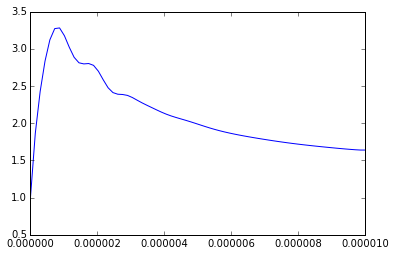

In [31]:
pyplot.plot(x, Pf[:,0]/P_inf );

In [32]:
### X-momentum

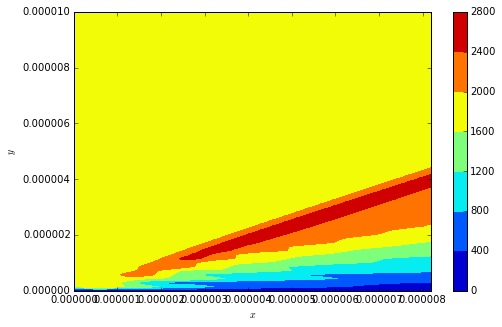

In [33]:
pyplot.figure(figsize=(8,5))
pyplot.contourf(my,mx,US[-1,1,:,:])
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();

In [34]:
### Y-momentum

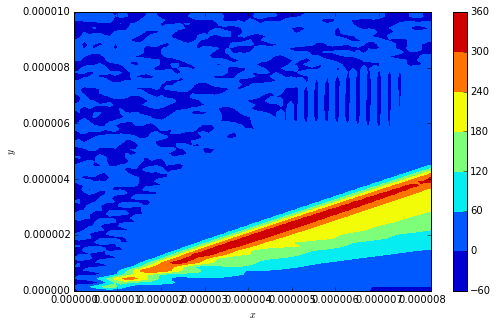

In [35]:
pyplot.figure(figsize=(8,5))
pyplot.contourf(my,mx,US[-1,2,:,:])
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();

In [36]:
### Total Energy

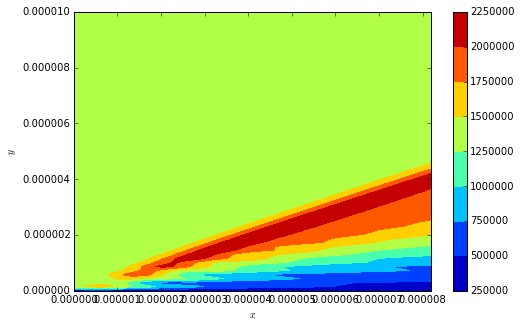

In [37]:
pyplot.figure(figsize=(8,5))
pyplot.contourf(my,mx,US[-1,3,:,:])
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();

## Animate!

In [40]:
# fig = pyplot.figure(figsize=(8,5))

# ims = []

# for i in range(0,5000,100):
#     im = pyplot.contourf(my,mx,US[i,0,:,:])
#     def setvisible(self,vis):
#         for c in self.collections: c.set_visible(vis)
#     im.set_visible = types.MethodType(setvisible,im)
#     im.axes = pylab.gca()
#     im.figure=fig
#     #pyplot.colorbar()
#     ims.append([im])


In [41]:
# #ani = animation.FuncAnimation(fig,ims)
# ani = animation.ArtistAnimation(fig, ims)
# display_animation(ani, default_mode='once')
